In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as pl
from matplotlib import rcParams
import scanpy as sc
import igraph as ig
import re
import warnings
from collections import Counter
from scipy.stats import mannwhitneyu
from statsmodels.miscmodels.ordinal_model import OrderedModel
from statsmodels.miscmodels.ordinal_model import OrderedModel
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats import ranksums
from scipy.stats import mannwhitneyu
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt

import umap
import sklearn.datasets
import umap.plot

import collections

import scipy as sp
from scipy.linalg import block_diag
import numpy as np
import matplotlib.pylab as pl
from mpl_toolkits.mplot3d import Axes3D  # noqa
import ot
warnings.filterwarnings("ignore")

# 0. Parameters

In [11]:
# ROSMAP
ROSMAP_Exp_File = "../../../Data/ROSMAP_blood_gene_expression_monocyte_ACTL_04172023.csv"
ROSMAP_Clinical_File = "../../../Data/ROSMAP_blood_clinical_monocyte_ACTL_04172023.csv"

# ADNI
ANMerge_Exp_File = "../../../Data/ANMerge_blood_rna_gene_expr_removedbatch_02022024.csv"
ANMerge_Clinical_File = "../../../Data/ANMerge_blood_rna_clinical_processed_XH_10112023.csv"
ANMerge_Longit_File = "../../../Data/ANMerge_clinical_under_90.csv"

# A. Load data

## A1. Load Rosmap Blood data

In [12]:
# load data
# Blood ROSMAP
ROSMAPFrame = pd.read_csv(ROSMAP_Exp_File,header=0, index_col=0)
ROSMAPSampleID = list(ROSMAPFrame.columns.values)
ROSMAPGeneID = list(ROSMAPFrame.index.values)

# read in label
ROSMAP_Info = pd.read_csv(ROSMAP_Clinical_File,header=0, index_col=0)

In [13]:
ROSMAPFrame.head(2)

,Sample_003,Sample_004,Sample_014,Sample_021,Sample_031,Sample_037,Sample_040,Sample_050,Sample_057,Sample_058,...,Sample_563,Sample_572,Sample_573,Sample_578,Sample_580,Sample_581,Sample_582,Sample_588,Sample_590,Sample_608
A1BG,4.0,1,2,14.0,1.0,4.0,7,5.0,2,8,...,5.0,10.0,18,8,2,0,0.5,0,12.0,1.0
A2M,5.0,0,0,18.0,4.0,22.0,34,21.0,6,8,...,7.0,9.0,13,14,6,1,0.0,0,11.0,26.0


In [14]:
ROSMAP_Info

,individualID,projid,msex,race,apoe_genotype,age_at_visit_max,age_death,cts_mmse30_lv,pmi,braaksc,ceradsc,cogdx,dcfdx_lv,Group1,Group2,specimenID
1,R1528689,402800,0,1,34.0,79.701574264202605,80.65708418891171,13.0,5.500000,5,1,4,4,Typical AD,Typical.AD,Sample_003
2,R3978789,482428,0,1,23.0,82.321697467488022,83.690622861054067,30.0,3.933333,4,4,1,1,Asym AD,Asym.AD,Sample_004
3,R5422277,3052480,0,1,23.0,90+,90+,15.0,10.583333,4,2,2,2,Asym AD,Asym.AD,Sample_014
4,R1408411,4127190,0,1,23.0,87.750855578370974,88.637919233401774,29.0,18.166667,2,4,1,1,Control,Control,Sample_021
5,R9033345,6107196,1,1,33.0,90+,90+,22.0,4.166667,5,1,4,4,Typical AD,Typical.AD,Sample_031
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
153,R4937504,92393245,0,1,23.0,90+,90+,26.0,8.283333,5,1,1,1,Asym AD,Asym.AD,Sample_581
154,R6119857,92427316,1,1,33.0,88.662559890485966,89.226557152635181,24.0,43.883333,4,1,1,1,Asym AD,Asym.AD,Sample_582
155,R8186418,93787649,1,1,33.0,86.132785763175903,86.35455167693361,27.0,4.250000,1,2,5,5,Low-NFT AD,LowNFT.AD,Sample_588
156,R2157677,94144536,0,1,33.0,90+,90+,24.0,8.216667,5,1,2,2,Asym AD,Asym.AD,Sample_590


### A1.1 Extract features

In [15]:
ROSMAP_SID = list(ROSMAP_Info.loc[:,'specimenID'])
ROSMAP_Class = list(ROSMAP_Info.loc[:,'Group1'])
ROSMAP_Sex = list(ROSMAP_Info.loc[:,'msex']) # 1->male 0->female reference: https://rpubs.com/tiagochst/AD_supplemental_ROSMAP_dataset
ROSMAP_Gender = list(ROSMAP_Info.loc[:,'msex']) # 1->male 0->female reference: https://rpubs.com/tiagochst/AD_supplemental_ROSMAP_dataset
ROSMAP_Age = list(ROSMAP_Info.loc[:,'age_at_visit_max'])
ROSMAP_braaksc = list(ROSMAP_Info.loc[:,'braaksc'])
ROSMAP_ceradsc = list(ROSMAP_Info.loc[:,'ceradsc'])
ROSMAP_cogdx = list(ROSMAP_Info.loc[:,'cogdx'])
ROSMAP_apeo_genotype = list(ROSMAP_Info.loc[:,'apoe_genotype'])
ROSMAP_cts_mmse30 = list(ROSMAP_Info.loc[:,'cts_mmse30_lv'])
ROSMAP_pmi = list(ROSMAP_Info.loc[:,'pmi'])
ROSMAP_dcfdx = list(ROSMAP_Info.loc[:,'dcfdx_lv'])

#print(ROSMAP_Gender)

# reomve characters in age
for i in range(len(ROSMAP_Age)):
    ROSMAP_Age[i] = round(float(re.findall(r"[-+]?(?:\d*\.*\d+)", ROSMAP_Age[i])[0]))
    ROSMAP_braaksc[i] = int(ROSMAP_braaksc[i])
    ROSMAP_ceradsc[i] = int(ROSMAP_ceradsc[i])
    ROSMAP_cogdx[i] = int(ROSMAP_cogdx[i])
    if ROSMAP_Gender[i] == 1:
        ROSMAP_Gender[i] = 'Male'
    else:
        ROSMAP_Gender[i] = 'Female'
#print(ROSMAP_Age)
#print(ROSMAP_Gender)


# dic for different feature
Mapping_ID_Class = dict(zip(ROSMAP_SID, ROSMAP_Class))
Mapping_ID_Class_ROSMAP = dict(zip(ROSMAP_SID, ROSMAP_Class))
Mapping_ID_Gender = dict(zip(ROSMAP_SID, ROSMAP_Gender))
Mapping_ID_Age = dict(zip(ROSMAP_SID, ROSMAP_Age))
Mapping_ID_braaksc = dict(zip(ROSMAP_SID, ROSMAP_braaksc))
Mapping_ID_ceradsc = dict(zip(ROSMAP_SID, ROSMAP_ceradsc))
Mapping_ID_cogdx = dict(zip(ROSMAP_SID, ROSMAP_cogdx))
Mapping_ID_apeo_genotype = dict(zip(ROSMAP_SID, ROSMAP_apeo_genotype))
Mapping_ID_cts_mmse30 = dict(zip(ROSMAP_SID, ROSMAP_cts_mmse30))
Mapping_ID_pmi = dict(zip(ROSMAP_SID, ROSMAP_pmi))
Mapping_ID_dcfdx = dict(zip(ROSMAP_SID, ROSMAP_dcfdx))
Mapping_ID_Sex = dict(zip(ROSMAP_SID, ROSMAP_Sex))


In [16]:
# Mapping from ROSMAPSampleID
ROSMAPSampleID_Class = list()
ROSMAPSampleID_Gender = list()
ROSMAPSampleID_Age = list()
ROSMAPSampleID_braaksc = list()
ROSMAPSampleID_ceradsc = list()
ROSMAPSampleID_cogdx = list()
ROSMAPSampleID_apeo_genotype = list()
ROSMAPSampleID_cts_mmse30 = list()
ROSMAPSampleID_pmi = list()
ROSMAPSampleID_dcfdx = list()
ROSMAPSampleID_Sex = list()

for idt in ROSMAPSampleID:
    ROSMAPSampleID_Class.append(Mapping_ID_Class[idt])
    ROSMAPSampleID_Gender.append(Mapping_ID_Gender[idt])
    ROSMAPSampleID_Age.append(Mapping_ID_Age[idt])
    ROSMAPSampleID_braaksc.append(Mapping_ID_braaksc[idt])
    ROSMAPSampleID_ceradsc.append(Mapping_ID_ceradsc[idt])
    ROSMAPSampleID_cogdx.append(Mapping_ID_cogdx[idt])
    ROSMAPSampleID_apeo_genotype.append(Mapping_ID_apeo_genotype[idt])
    ROSMAPSampleID_cts_mmse30.append(Mapping_ID_cts_mmse30[idt])
    ROSMAPSampleID_pmi.append(Mapping_ID_pmi[idt])
    ROSMAPSampleID_dcfdx.append(Mapping_ID_dcfdx[idt])
    ROSMAPSampleID_Sex.append(Mapping_ID_Sex[idt])
    

# Convert to anndata
anndata_ROSMAP = sc.AnnData(ROSMAPFrame.T)
anndata_ROSMAP.obs['Label']=ROSMAPSampleID_Class
anndata_ROSMAP.obs['Gender']=ROSMAPSampleID_Gender
anndata_ROSMAP.obs['Age']=ROSMAPSampleID_Age
anndata_ROSMAP.obs['braaksc']=ROSMAPSampleID_braaksc
anndata_ROSMAP.obs['ceradsc']=ROSMAPSampleID_ceradsc
anndata_ROSMAP.obs['cogdx']=ROSMAPSampleID_cogdx
anndata_ROSMAP.obs['apeo_genotype']=ROSMAPSampleID_apeo_genotype
anndata_ROSMAP.obs['cts_mmse30']=ROSMAPSampleID_cts_mmse30
anndata_ROSMAP.obs['pmi']=ROSMAPSampleID_pmi
anndata_ROSMAP.obs['dcfdx']=ROSMAPSampleID_dcfdx
anndata_ROSMAP.obs['Sex']=ROSMAPSampleID_Sex
anndata_ROSMAP.var['gene_short_name'] = ROSMAPGeneID
anndata_ROSMAP.X = anndata_ROSMAP.X.astype('float64') 


In [17]:
anndata_ROSMAP.obs.head(2)

,Label,Gender,Age,braaksc,ceradsc,cogdx,apeo_genotype,cts_mmse30,pmi,dcfdx,Sex
Sample_003,Typical AD,Female,80,5,1,4,34.0,13.0,5.500000,4,0
Sample_004,Asym AD,Female,82,4,4,1,23.0,30.0,3.933333,1,0


## A2. Load ANMerge data

In [18]:
# load data
# Blood ROSMAP
ANMergeFrame = pd.read_csv(ANMerge_Exp_File,header=0, index_col=0)
ANMergeSampleID = list(ANMergeFrame.columns.values)
ANMergeGeneID = list(ANMergeFrame.index.values)

# read in clinical
ANMerge_Info = pd.read_csv(ANMerge_Clinical_File,header=0, index_col=0)


# read in longitudinal data
# read in transferred label
ANMerge_Log = pd.read_csv(ANMerge_Longit_File,header=0, index_col=0)



In [19]:
ANMergeFrame.head(2)

,DCR00001_1,DCR00004_1,DCR00009_1,DCR00013_1,DCR00014_1,DCR00015_1,DCR00018_1,DCR00020_1,DCR00021_1,DCR00025_1,...,TLSMCI602_1,TLSMCI603_1,TLSMCI604_1,TLSMCI605_1,TLSMCI606_1,TLSMCI607_1,TLSMCI608_1,TLSMCI609_1,TLSMCI611_1,TLSMCI612_1
OCIAD2,7.202189,7.592913,7.818567,7.672523,8.088279,7.906253,7.883186,8.189109,8.115927,8.087568,...,7.494859,7.715155,7.597167,7.841250,7.787517,8.51477,7.173792,8.480899,7.547185,7.249778
ERICH1,8.128490,8.376996,8.172010,7.885014,7.990907,8.009679,8.505735,8.159569,7.935684,7.606562,...,8.133853,7.326263,8.092895,7.922329,8.364469,8.05262,8.021777,8.463299,8.188147,8.569959


In [20]:
ANMerge_Info.head(5)

,Visit,Month,Site,Diagnosis,Sex,Age,APOE,MMSE,Gexp_batch
DCR00001_1,1,0,DCR,AD,Female,80.0,E3E4,21.0,2
DCR00004_1,1,0,DCR,MCI,Male,78.0,E4E4,27.0,2
DCR00009_1,1,0,DCR,CTL,Female,69.0,E3E3,30.0,2
DCR00013_1,1,0,DCR,CTL,Male,82.0,E3E3,30.0,2
DCR00014_1,1,0,DCR,CTL,Female,75.0,E2E3,30.0,2


In [21]:
ANMerge_Log

,Subject_ID,Sadman_ID,Site,Month,Visit,Max_Visit,Sex,Diagnosis,BL_Diagnosis,Final_Diagnosis,...,Mother_Dementia,NPI,Onset_Age,Onset_Pattern,Onset_Year,Progression_Pattern,Sensory_Impairment,TICSM,Webster,SNP_batch
DCR00001_1,DCR00001,DCR00001,DCR,0,1,2,Female,AD,AD,AD,...,No,20.0,80.0,Sudden,2007.0,Fluctuating_variable,1.0,NaN,2.0,NaN
DCR00001_2,DCR00001,DCR00001,DCR,12,2,2,Female,AD,AD,AD,...,No,87.0,80.0,Sudden,2007.0,NaN,1.0,NaN,22.0,NaN
DCR00003_1,DCR00003,DCR00003,DCR,0,1,7,Female,AD,AD,AD,...,No,0.0,NaN,Gradual,2006.0,Slowly_progressive,1.0,NaN,0.0,NaN
DCR00003_2,DCR00003,DCR00003,DCR,12,2,7,Female,AD,AD,AD,...,No,NaN,NaN,Gradual,2006.0,NaN,1.0,NaN,0.0,NaN
DCR00003_3,DCR00003,DCR00003,DCR,24,3,7,Female,AD,AD,AD,...,No,8.0,NaN,Gradual,2006.0,NaN,1.0,NaN,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TLSMCI611_2,TLSMCI611,TLSM0611,Toulouse,12,2,2,Female,MCI,MCI,MCI,...,Do_not_know,NaN,77.0,NaN,2005.0,NaN,1.0,NaN,NaN,NaN
TLSMCI612_1,TLSMCI612,TLSM0612,Toulouse,0,1,2,Female,MCI,MCI,AD,...,No,NaN,77.0,NaN,2005.0,NaN,1.0,NaN,NaN,NaN
TLSMCI612_2,TLSMCI612,TLSM0612,Toulouse,12,2,2,Female,AD,MCI,AD,...,Do_not_know,NaN,77.0,NaN,2005.0,NaN,1.0,NaN,NaN,NaN
TLSMCI613_1,TLSMCI613,TLSM0613,Toulouse,0,1,2,Male,MCI,MCI,MCI,...,No,NaN,78.0,NaN,2005.0,NaN,0.0,NaN,NaN,NaN


In [22]:
ANMerge_Log.loc["DCR00001_1",:].MMSE

21.0

In [23]:
print(list(ANMerge_Log.columns))

['Subject_ID', 'Sadman_ID', 'Site', 'Month', 'Visit', 'Max_Visit', 'Sex', 'Diagnosis', 'BL_Diagnosis', 'Final_Diagnosis', 'Age', 'ADAS_COG', 'ADCS_ADL', 'APOE', 'CDR_SOB', 'CDR_Total', 'CERAD_A_Total', 'CERAD_B_Total', 'CERAD_C_Total', 'CERAD_D_Total', 'CERAD_E_Correct', 'CERAD_E_Intrusions', 'CERAD_F_Total', 'CERAD_G_Total', 'Cant_Read_Total', 'DEMQOL', 'Father_Dementia', 'Fulltime_Education_Years', 'Geriatric_Depression', 'Global_Deterioration_Scale', 'Hachinski', 'MMSE', 'MOCA', 'Marital_Status', 'Mother_Dementia', 'NPI', 'Onset_Age', 'Onset_Pattern', 'Onset_Year', 'Progression_Pattern', 'Sensory_Impairment', 'TICSM', 'Webster', 'SNP_batch']


### A2.1 Extract features

In [24]:
OnsetAge = list()
OnsetPattern = list()
MMSE = list()
CDR_Total = list()
CDR_SOB = list()
for i in range(len(ANMergeSampleID)):
    IDt = ANMergeSampleID[i]
    DFt = ANMerge_Log.loc[IDt,:]
    #print(i, ANMergeSampleID[i])
    
    # Onset Age
    if str(DFt.Onset_Age) == 'nan' or DFt.Onset_Age == 0:
        OnsetAge.append(np.inf)
        #print('nan')
    else:
        OnsetAge.append(DFt.Onset_Age)
        #print(DFtt['Onset_Age'].values[0])
    
    # Onset Pattern
    OnsetPattern.append(str(DFt.Onset_Pattern))
    
    if str(DFt.MMSE) == 'nan':
        MMSE.append(np.inf)
    else:
        MMSE.append(DFt.MMSE)
        
    if str(DFt.CDR_SOB) == 'nan':
        CDR_SOB.append(np.inf)
    else:
        CDR_SOB.append(DFt.CDR_SOB)
        
    if str(DFt.CDR_Total) == 'nan':
        CDR_Total.append(np.inf)
    else:
        CDR_Total.append(DFt.CDR_Total)
    

Mapping_ID_OnsetAge = dict(zip(ANMergeSampleID, OnsetAge))
Mapping_ID_OnsetPattern = dict(zip(ANMergeSampleID, OnsetPattern))
Mapping_ID_MMSE= dict(zip(ANMergeSampleID, MMSE))
Mapping_ID_CDRSOB = dict(zip(ANMergeSampleID, CDR_SOB))
Mapping_ID_CDRTotal= dict(zip(ANMergeSampleID, CDR_Total))

In [25]:
ANMerge_SID = list(ANMerge_Info.index)
ANMerge_Gender = list(ANMerge_Info.loc[:,'Sex']) 
ANMerge_Age = list(ANMerge_Info.loc[:,'Age'])
ANMerge_DX = list(ANMerge_Info.loc[:,'Diagnosis'])
ANMerge_Site = list(ANMerge_Info.loc[:,'Site'])
ANMerge_Batch = list(ANMerge_Info.loc[:,'Gexp_batch'])

# data cleaning
ANMerge_Age = np.array(ANMerge_Age)
for i in range(len(ANMerge_Age)):
    if ANMerge_Age[i] == 'NaN':
        ANMerge_Age[i] = np.inf
ANMerge_Age[np.isnan(ANMerge_Age)] = np.inf
#print(ANMerge_Age)

#for i in range(len(ANMerge_Age)):
#    ANMerge_Age[i] = round(float(ANMerge_Age[i]))
#print(ADNI_Age)
#print(ADNI_Gender)


# dic for different feature
Mapping_ID_Gender = dict(zip(ANMerge_SID, ANMerge_Gender))
Mapping_ID_Age = dict(zip(ANMerge_SID, ANMerge_Age))
Mapping_ID_DX = dict(zip(ANMerge_SID, ANMerge_DX))
Mapping_ID_Site = dict(zip(ANMerge_SID, ANMerge_Site))
Mapping_ID_Batch = dict(zip(ANMerge_SID, ANMerge_Batch))


In [26]:
# Mapping from ADNISampleID
ANMergeSampleID_Class = list()
ANMergeSampleID_Gender = list()
ANMergeSampleID_Age = list()
ANMergeSampleID_DX = list()
ANMergeSampleID_Site = list()
ANMergeSampleID_Batch = list()
ANMergeSampleID_OnsetAge = list()
ANMergeSampleID_OnsetPattern = list()
ANMergeSampleID_MMSE = list()
ANMergeSampleID_CDRSOB = list()
ANMergeSampleID_CDRTotal = list()
for idt in ANMerge_SID:
    ANMergeSampleID_Gender.append(Mapping_ID_Gender[idt])
    ANMergeSampleID_Age.append(Mapping_ID_Age[idt])
    ANMergeSampleID_DX.append(Mapping_ID_DX[idt])
    ANMergeSampleID_Site.append(Mapping_ID_Site[idt])
    ANMergeSampleID_Batch.append(Mapping_ID_Batch[idt])
    ANMergeSampleID_OnsetAge.append(Mapping_ID_OnsetAge[idt])
    ANMergeSampleID_OnsetPattern.append(Mapping_ID_OnsetPattern[idt])
    
    ANMergeSampleID_MMSE.append(Mapping_ID_MMSE[idt])
    ANMergeSampleID_CDRSOB.append(Mapping_ID_CDRSOB[idt])
    ANMergeSampleID_CDRTotal.append(Mapping_ID_CDRTotal[idt])
    

# Convert to anndata
anndata_ANMerge = sc.AnnData(ANMergeFrame.T)
anndata_ANMerge.obs['Gender']=ANMergeSampleID_Gender
anndata_ANMerge.obs['Age']=ANMergeSampleID_Age
anndata_ANMerge.obs['DX']=ANMergeSampleID_DX
anndata_ANMerge.obs['Site']=ANMergeSampleID_Site
anndata_ANMerge.obs['Batch']=ANMergeSampleID_Batch
anndata_ANMerge.obs['OnsetAge']=ANMergeSampleID_OnsetAge
anndata_ANMerge.obs['OnsetPattern']=ANMergeSampleID_OnsetPattern
anndata_ANMerge.var['gene_short_name'] = ANMergeGeneID
anndata_ANMerge.obs['MMSE']=ANMergeSampleID_MMSE
anndata_ANMerge.obs['CDRSOB']=ANMergeSampleID_CDRSOB
anndata_ANMerge.obs['CDRTotal']=ANMergeSampleID_CDRTotal
anndata_ANMerge.X = anndata_ANMerge.X.astype('float64') 


In [27]:
tt = list(anndata_ANMerge.obs.CDRSOB)
counter = collections.Counter(tt)
print(counter)

Counter({0.0: 196, 0.5: 77, 1.0: 50, 1.5: 47, inf: 36, 2.5: 33, 4.5: 31, 2.0: 28, 6.0: 27, 4.0: 21, 9.0: 18, 3.5: 15, 3.0: 14, 7.0: 14, 8.0: 13, 5.0: 12, 5.5: 12, 11.0: 9, 12.0: 9, 13.0: 8, 10.0: 7, 6.5: 6, 7.5: 4, 8.5: 2, 15.0: 1, 14.0: 1})


In [28]:
tt = list(anndata_ANMerge.obs.CDRTotal)
counter = collections.Counter(tt)
print(counter)

Counter({0.5: 260, 0.0: 222, 1.0: 132, 2.0: 42, inf: 34, 3.0: 1})


In [29]:
anndata_ANMerge

AnnData object with n_obs × n_vars = 691 × 4849
    obs: 'Gender', 'Age', 'DX', 'Site', 'Batch', 'OnsetAge', 'OnsetPattern', 'MMSE', 'CDRSOB', 'CDRTotal'
    var: 'gene_short_name'

# B. Data nomrlization

In [30]:
anndata_ROSMAP

AnnData object with n_obs × n_vars = 157 × 7704
    obs: 'Label', 'Gender', 'Age', 'braaksc', 'ceradsc', 'cogdx', 'apeo_genotype', 'cts_mmse30', 'pmi', 'dcfdx', 'Sex'
    var: 'gene_short_name'

In [31]:
anndata_ANMerge

AnnData object with n_obs × n_vars = 691 × 4849
    obs: 'Gender', 'Age', 'DX', 'Site', 'Batch', 'OnsetAge', 'OnsetPattern', 'MMSE', 'CDRSOB', 'CDRTotal'
    var: 'gene_short_name'

In [32]:
TopGeneROSMAP = list(anndata_ROSMAP.var.index)
TOpGeneANMerge = list(anndata_ANMerge.var.index)

TopGeneOverlap = list(set(TopGeneROSMAP) & set(TOpGeneANMerge))

print("The overlaps of highly variable genes are ", len(TopGeneOverlap))

The overlaps of highly variable genes are  2785


In [33]:
anndata_ROSMAP_Top = anndata_ROSMAP[:,TopGeneOverlap]
anndata_ANMerge_Top = anndata_ANMerge[:,TopGeneOverlap]


In [34]:
# pick only top 5000 highly variable genes
Ntop1 = len(TopGeneOverlap)
Ntop2 = len(TopGeneOverlap)
#sc.pp.recipe_zheng17(anndata_ROSMAP_Top, n_top_genes=Ntop1)
#sc.pp.recipe_zheng17(anndata_ANMerge_Top, n_top_genes=Ntop2, log=False)


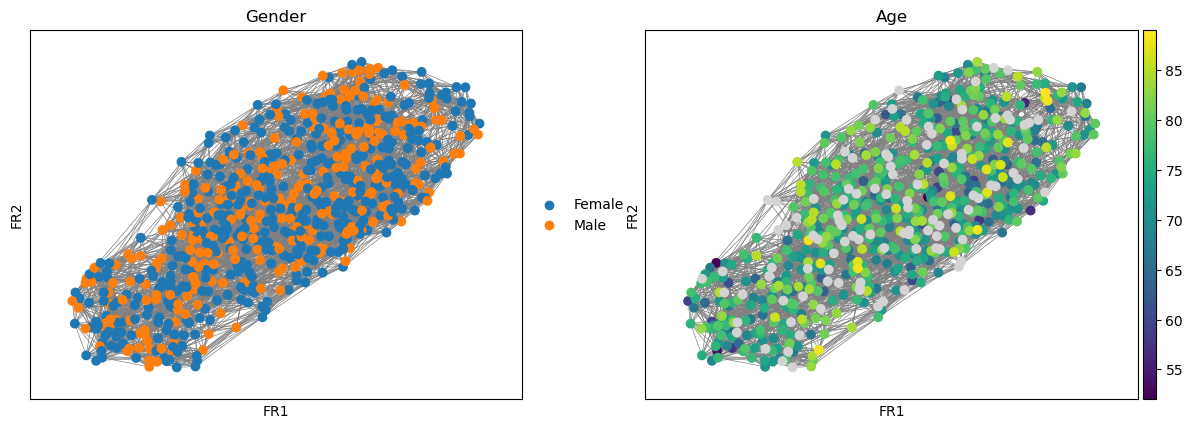

In [35]:
sc.tl.pca(anndata_ANMerge_Top, svd_solver='arpack', n_comps=50)
sc.pp.neighbors(anndata_ANMerge_Top, n_neighbors=15, n_pcs=50)  ## avoid clustering
sc.tl.draw_graph(anndata_ANMerge_Top)

sc.pl.draw_graph(anndata_ANMerge_Top, color=['Gender','Age'], legend_loc='right margin', size=200, edges=True, edges_width=0.5) 


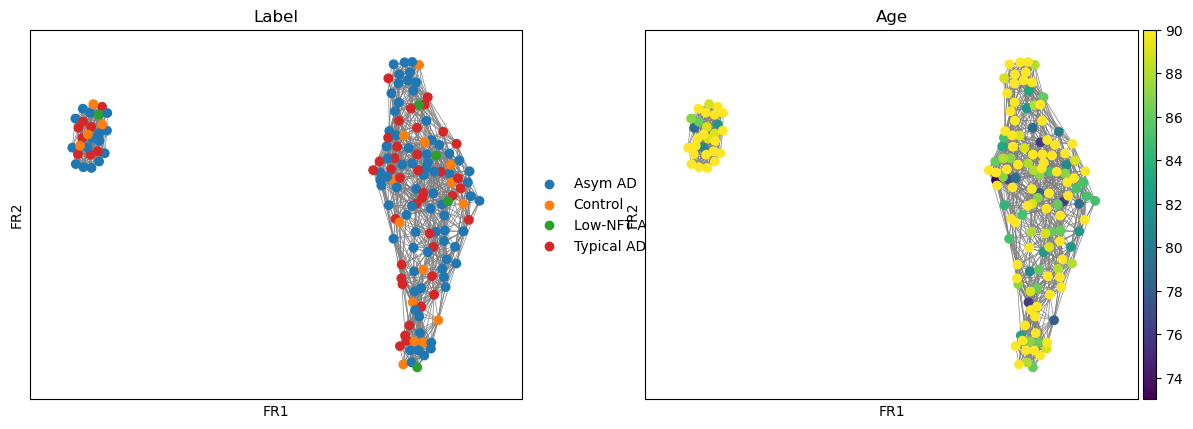

In [36]:
sc.tl.pca(anndata_ROSMAP_Top, svd_solver='arpack', n_comps=50)
sc.pp.neighbors(anndata_ROSMAP_Top, n_neighbors=15, n_pcs=50)  ## avoid clustering
sc.tl.draw_graph(anndata_ROSMAP_Top)

sc.pl.draw_graph(anndata_ROSMAP_Top, color=['Label','Age'], legend_loc='right margin', size=200, edges=True, edges_width=0.5) 


In [37]:
sc.tl.louvain(anndata_ROSMAP_Top, resolution=0.01)

In [38]:
anndata_ROSMAP_Cloud0 = anndata_ROSMAP_Top[anndata_ROSMAP_Top.obs.louvain=='0']
anndata_ROSMAP_Cloud1 = anndata_ROSMAP_Top[anndata_ROSMAP_Top.obs.louvain=='1']

In [39]:
anndata_ROSMAP_Cloud0.obs

,Label,Gender,Age,braaksc,ceradsc,cogdx,apeo_genotype,cts_mmse30,pmi,dcfdx,Sex,louvain
Sample_003,Typical AD,Female,80,5,1,4,34.0,13.0,5.500000,4,0,0
Sample_004,Asym AD,Female,82,4,4,1,23.0,30.0,3.933333,1,0,0
Sample_021,Control,Female,88,2,4,1,23.0,29.0,18.166667,1,0,0
Sample_031,Typical AD,Male,90,5,1,4,33.0,22.0,4.166667,4,1,0
Sample_037,Asym AD,Male,87,4,2,2,24.0,28.0,8.416667,2,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_580,Asym AD,Female,88,5,1,2,33.0,24.0,4.766667,2,0,0
Sample_581,Asym AD,Female,90,5,1,1,23.0,26.0,8.283333,1,0,0
Sample_588,Low-NFT AD,Male,86,1,2,5,33.0,27.0,4.250000,5,1,0
Sample_590,Asym AD,Female,90,5,1,2,33.0,24.0,8.216667,2,0,0


In [40]:
anndata_ROSMAP_Cloud1.obs.shape

(28, 12)

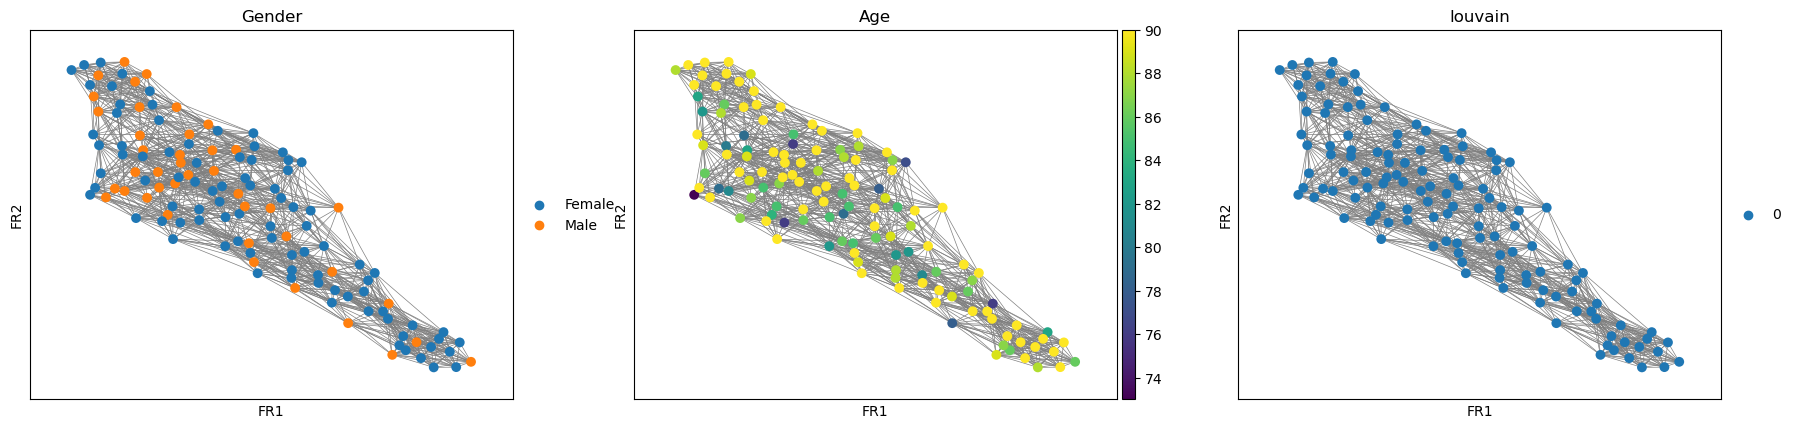

In [41]:
sc.tl.pca(anndata_ROSMAP_Cloud0, svd_solver='arpack', n_comps=50)
sc.pp.neighbors(anndata_ROSMAP_Cloud0, n_neighbors=15, n_pcs=50)  ## avoid clustering
sc.tl.draw_graph(anndata_ROSMAP_Cloud0)

sc.pl.draw_graph(anndata_ROSMAP_Cloud0, color=['Gender','Age','louvain'], legend_loc='right margin', size=200, edges=True, edges_width=0.5) 


# C. OPT

In [42]:
anndata_ROSMAP_Top# = anndata_ROSMAP_Cloud0

AnnData object with n_obs × n_vars = 157 × 2785
    obs: 'Label', 'Gender', 'Age', 'braaksc', 'ceradsc', 'cogdx', 'apeo_genotype', 'cts_mmse30', 'pmi', 'dcfdx', 'Sex', 'louvain'
    var: 'gene_short_name'
    uns: 'pca', 'neighbors', 'draw_graph', 'Label_colors', 'louvain'
    obsm: 'X_pca', 'X_draw_graph_fr'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [43]:
anndata_ANMerge_Top.X.shape

(691, 2785)

In [44]:
M = ot.dist(np.array(anndata_ROSMAP_Top.X), anndata_ANMerge_Top.X, metric='sqeuclidean')
M /= M.max()

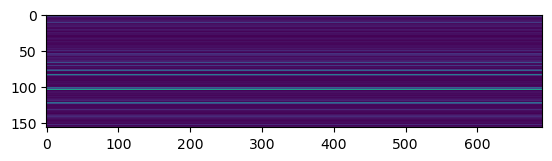

In [45]:
pl.imshow(M)


In [46]:
a = ot.unif(M.shape[0])
b = ot.unif(M.shape[1])

In [47]:
#Solve EMD with entropic regularization
def f(G):
    return 0.5 * np.sum(G**2)


def df(G):
    return G


reg1 = 1e-3
reg2 = 1e-1

Ge = ot.emd(a, b, M)


#Ge = ot.optim.cg(a, b, M, reg1, reg2, f, df, verbose=True)

#pl.figure(3, figsize=(5, 5))
#ot.plot.plot1D_mat(a, b, Ge, 'OT matrix Entrop. reg')


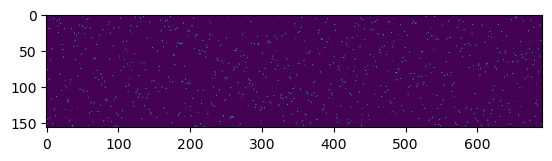

In [48]:
pl.imshow(Ge)


# D. Analyze the results

## D.1 brak score transfer

In [49]:
Pe = Ge/Ge.sum(axis=1,keepdims=1)

In [50]:
ROSMAP_New = Pe @ anndata_ANMerge_Top.X

<Axes: >

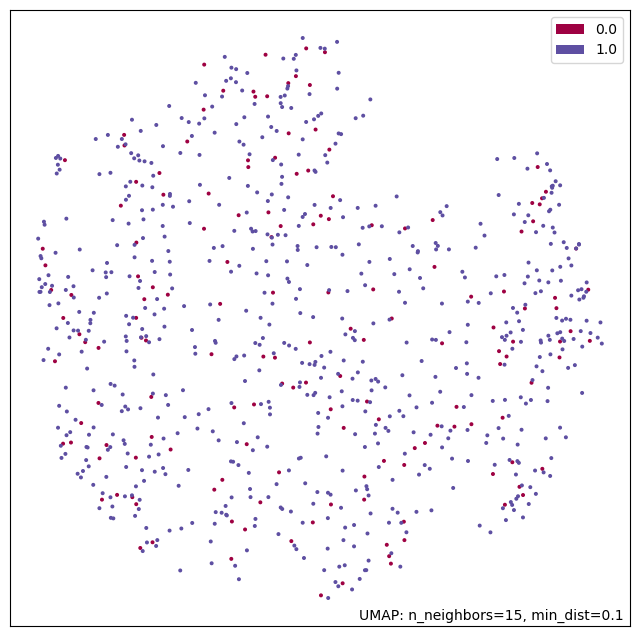

In [51]:
# Umap need a matrix obs by features
Embed_Stack = np.vstack((ROSMAP_New,anndata_ANMerge_Top.X))

# label
N_K1 = np.shape(ROSMAP_New)[0]
Label = np.zeros(np.shape(Embed_Stack)[0])
Label[N_K1:] = 1

mapper = umap.UMAP().fit(Embed_Stack)

umap.plot.points(mapper, labels=Label)

In [52]:
anndata_ROSMAP_Top.layers["OPT_Em_ANMerge"] =  ROSMAP_New

In [53]:
np.array(anndata_ROSMAP_Top.obs['braaksc'])

array([5, 4, 4, 2, 5, 4, 4, 2, 4, 5, 4, 5, 4, 4, 4, 4, 4, 5, 4, 4, 4, 5,
       4, 4, 1, 5, 5, 5, 4, 5, 5, 4, 5, 5, 5, 4, 4, 1, 4, 5, 4, 5, 5, 4,
       4, 5, 5, 4, 5, 4, 4, 5, 0, 4, 4, 4, 5, 4, 4, 5, 4, 4, 4, 4, 5, 5,
       4, 5, 5, 4, 5, 4, 4, 4, 4, 4, 4, 2, 4, 5, 5, 4, 4, 4, 5, 1, 1, 5,
       4, 4, 5, 5, 5, 4, 0, 5, 2, 5, 4, 1, 4, 5, 2, 5, 2, 2, 4, 4, 4, 5,
       1, 2, 1, 4, 4, 2, 6, 5, 4, 5, 5, 5, 5, 5, 4, 5, 5, 4, 5, 6, 4, 2,
       5, 5, 5, 4, 5, 5, 4, 5, 4, 4, 0, 0, 5, 4, 5, 4, 4, 1, 5, 5, 5, 4,
       1, 5, 4])

In [54]:
# bakk score transfer

from sklearn.neighbors import KNeighborsClassifier

ROSMAP_new_ = ROSMAP_New
Bakk = np.array(anndata_ROSMAP_Top.obs['braaksc'])
neigh = KNeighborsClassifier(n_neighbors=1)
neigh.fit(ROSMAP_new_,Bakk)

KNeighborsClassifier(n_neighbors=1)

In [55]:
bakk_trans = np.zeros(anndata_ANMerge_Top.shape[0])
bakk_trans = -1+bakk_trans

for i in range(anndata_ANMerge_Top.shape[0]):
    bakk_trans[i] = neigh.predict([anndata_ANMerge_Top.X[i,:]])

In [56]:
counter = collections.Counter(bakk_trans)
print(counter)

Counter({4.0: 321, 5.0: 266, 2.0: 42, 1.0: 36, 0.0: 18, 6.0: 8})


In [57]:
anndata_ANMerge_Top.obs['braaksc_trans'] = bakk_trans

In [58]:
anndata_ANMerge_Top.obs

,Gender,Age,DX,Site,Batch,OnsetAge,OnsetPattern,MMSE,CDRSOB,CDRTotal,braaksc_trans
DCR00001_1,Female,80.0,AD,DCR,2,80.0,Sudden,21.0,5.0,1.0,4.0
DCR00004_1,Male,78.0,MCI,DCR,2,inf,nan,27.0,0.5,0.5,2.0
DCR00009_1,Female,69.0,CTL,DCR,2,inf,nan,30.0,0.0,0.0,2.0
DCR00013_1,Male,82.0,CTL,DCR,2,inf,nan,30.0,0.0,0.0,4.0
DCR00014_1,Female,75.0,CTL,DCR,2,inf,nan,30.0,inf,inf,5.0
...,...,...,...,...,...,...,...,...,...,...,...
TLSMCI607_1,Female,72.0,MCI,Toulouse,1,69.0,nan,29.0,1.0,0.5,5.0
TLSMCI608_1,Male,73.0,MCI,Toulouse,1,71.0,nan,28.0,1.0,0.5,4.0
TLSMCI609_1,Female,63.0,MCI,Toulouse,2,53.0,nan,28.0,0.5,0.5,4.0
TLSMCI611_1,Female,78.0,MCI,Toulouse,2,77.0,nan,30.0,1.0,0.5,4.0


## D.2 Classfy ADNI sampel based on brak score and crd score (Metrie I)

In [59]:
Label = list()
SID = list(anndata_ANMerge_Top.obs.index)

for gt in SID:
    CRD = anndata_ANMerge_Top.obs.loc[gt,:].CDRSOB
    Braak = anndata_ANMerge_Top.obs.loc[gt,:].braaksc_trans
    Dx = anndata_ANMerge_Top.obs.loc[gt,:].DX
    if CRD > 4 and Braak >=4:
        Label.append("Typical AD")
    elif CRD <= 4 and Braak >=4 and CRD > 0:
        Label.append("Asym AD")
    elif CRD > 4 and Braak <=2:
        Label.append("Low-NFT AD")
    elif CRD <= 0.5 and Braak <=2:
        Label.append("Control")
    else:
        Label.append("Others")
                                   

In [60]:
anndata_ANMerge_Top.obs['NewLabel'] = Label

In [61]:
anndata_ANMerge_Top_plt = anndata_ANMerge_Top.obs[anndata_ANMerge_Top.obs['NewLabel']!='Others']

In [62]:
anndata_ANMerge_Top_plt

,Gender,Age,DX,Site,Batch,OnsetAge,OnsetPattern,MMSE,CDRSOB,CDRTotal,braaksc_trans,NewLabel
DCR00001_1,Female,80.0,AD,DCR,2,80.0,Sudden,21.0,5.0,1.0,4.0,Typical AD
DCR00004_1,Male,78.0,MCI,DCR,2,inf,nan,27.0,0.5,0.5,2.0,Control
DCR00009_1,Female,69.0,CTL,DCR,2,inf,nan,30.0,0.0,0.0,2.0,Control
DCR00014_1,Female,75.0,CTL,DCR,2,inf,nan,30.0,inf,inf,5.0,Typical AD
DCR00018_1,Female,73.0,CTL,DCR,2,inf,nan,30.0,inf,inf,4.0,Typical AD
...,...,...,...,...,...,...,...,...,...,...,...,...
TLSMCI607_1,Female,72.0,MCI,Toulouse,1,69.0,nan,29.0,1.0,0.5,5.0,Asym AD
TLSMCI608_1,Male,73.0,MCI,Toulouse,1,71.0,nan,28.0,1.0,0.5,4.0,Asym AD
TLSMCI609_1,Female,63.0,MCI,Toulouse,2,53.0,nan,28.0,0.5,0.5,4.0,Asym AD
TLSMCI611_1,Female,78.0,MCI,Toulouse,2,77.0,nan,30.0,1.0,0.5,4.0,Asym AD


<Axes: xlabel='NewLabel', ylabel='MMSE'>

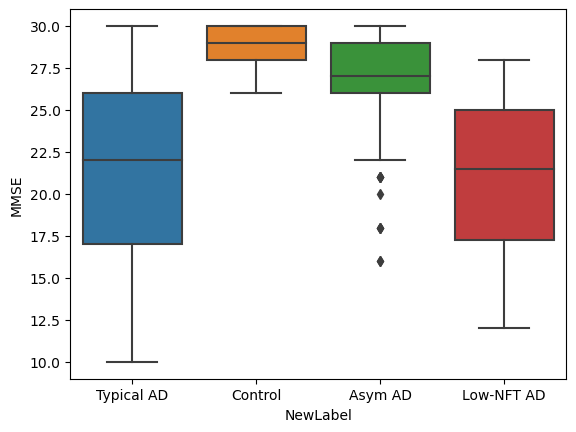

In [63]:
sns.boxplot(data=anndata_ANMerge_Top_plt, x='NewLabel', y='MMSE')

<Axes: xlabel='NewLabel', ylabel='MMSE'>

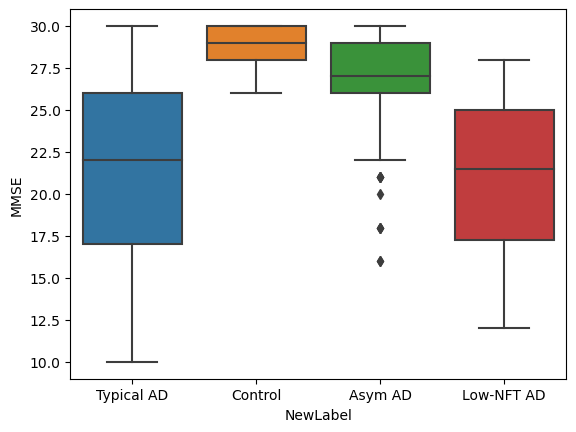

In [64]:
sns.boxplot(data=anndata_ANMerge_Top_plt, x='NewLabel', y='MMSE')

In [65]:
counter = collections.Counter(Label)
print(counter)

Counter({'Asym AD': 250, 'Others': 196, 'Typical AD': 172, 'Low-NFT AD': 38, 'Control': 35})


# E. Evaulation

In [66]:
df = anndata_ANMerge_Top.obs[anndata_ANMerge_Top.obs.NewLabel=='Asym AD']
counter = collections.Counter(df['DX'])
print(counter)
Acc_Asym = (counter['CTL'] + counter['MCI']) / df.shape[0]
print("Asym AD transfer accuracy is ", Acc_Asym)

Counter({'MCI': 176, 'AD': 42, 'CTL': 32})
Asym AD transfer accuracy is  0.832


In [67]:
df = anndata_ANMerge_Top.obs[anndata_ANMerge_Top.obs.NewLabel=='Typical AD']
counter = collections.Counter(df['DX'])
print(counter)
Acc_TAD = (counter['AD'] + counter['MCI']) / df.shape[0]
print("Typical AD transfer accuracy is ", Acc_TAD)

Counter({'AD': 141, 'CTL': 18, 'MCI': 13})
Typical AD transfer accuracy is  0.8953488372093024


In [68]:
df = anndata_ANMerge_Top.obs[anndata_ANMerge_Top.obs.NewLabel=='Low-NFT AD']
counter = collections.Counter(df['DX'])
print(counter)
Acc_LTau = (counter['AD'] + counter['MCI']) / df.shape[0]
print("Low-NFT AD transfer accuracy is ", Acc_LTau)

Counter({'AD': 33, 'MCI': 3, 'CTL': 2})
Low-NFT AD transfer accuracy is  0.9473684210526315


In [69]:
df = anndata_ANMerge_Top.obs[anndata_ANMerge_Top.obs.NewLabel=='Control']
counter = collections.Counter(df['DX'])
print(counter)
Acc_CN = (counter['CTL']) / df.shape[0]
print("Control transfer accuracy is ", Acc_CN)

Counter({'CTL': 27, 'MCI': 8})
Control transfer accuracy is  0.7714285714285715


In [70]:
df = anndata_ANMerge_Top.obs[anndata_ANMerge_Top.obs.NewLabel=='Others']
counter = collections.Counter(df['DX'])
print(counter)

Counter({'CTL': 170, 'MCI': 19, 'AD': 7})


In [71]:
Acc_Avg = (Acc_Asym + Acc_CN + Acc_LTau + Acc_TAD)/4
print("Avg acc is ", Acc_Avg)

Avg acc is  0.8615364574226263


## D.3 Classfy ADNI sampel based on brak score and crd score (Metrie II)

In [72]:
#print(np.array(anndata_ANMerge_Top.obs.CDRTotal))

In [73]:
Label = list()

for gt in SID:
    CRD = anndata_ANMerge_Top.obs.loc[gt,:].CDRSOB
    Braak = anndata_ANMerge_Top.obs.loc[gt,:].braaksc_trans
    Dx = anndata_ANMerge_Top.obs.loc[gt,:].DX
    if CRD > 4 and Braak >=4 and Dx == 'AD':
        Label.append("Typical AD")
    elif CRD <= 4 and Braak >=4 and CRD > 0:
        Label.append("Asym AD")
    elif CRD > 4 and Braak <=2:
        Label.append("Low-NFT AD")
    elif CRD <= 0.5 and Braak <=2 and Dx == 'CTL':
        Label.append("Control")
    else:
        Label.append("Others")
                                   

In [74]:
anndata_ANMerge_Top.obs['NewLabel'] = Label

In [75]:
anndata_ANMerge_Top_plt = anndata_ANMerge_Top.obs[anndata_ANMerge_Top.obs['NewLabel']!='Others']

In [76]:
#df[~df.isin([np.nan, np.inf, -np.inf]).any(1)]

<Axes: xlabel='NewLabel', ylabel='MMSE'>

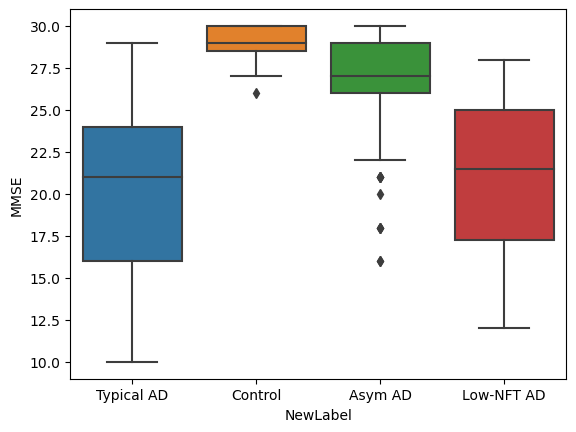

In [77]:
sns.boxplot(data=anndata_ANMerge_Top_plt, x='NewLabel', y='MMSE')

<Axes: xlabel='NewLabel', ylabel='MMSE'>

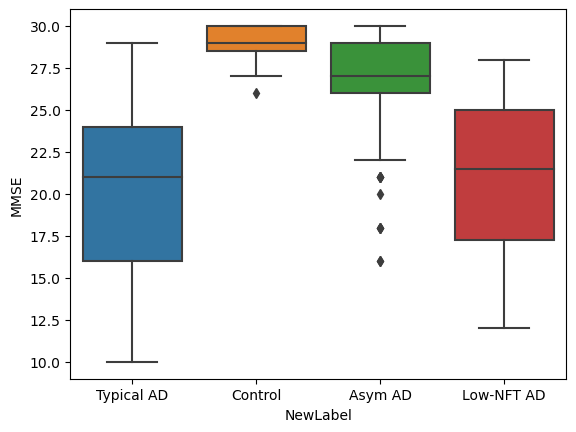

In [78]:
sns.boxplot(data=anndata_ANMerge_Top_plt, x='NewLabel', y='MMSE')

In [79]:
counter = collections.Counter(Label)
print(counter)

Counter({'Asym AD': 250, 'Others': 235, 'Typical AD': 141, 'Low-NFT AD': 38, 'Control': 27})


In [80]:
anndata_ANMerge_Top.obs

,Gender,Age,DX,Site,Batch,OnsetAge,OnsetPattern,MMSE,CDRSOB,CDRTotal,braaksc_trans,NewLabel
DCR00001_1,Female,80.0,AD,DCR,2,80.0,Sudden,21.0,5.0,1.0,4.0,Typical AD
DCR00004_1,Male,78.0,MCI,DCR,2,inf,nan,27.0,0.5,0.5,2.0,Others
DCR00009_1,Female,69.0,CTL,DCR,2,inf,nan,30.0,0.0,0.0,2.0,Control
DCR00013_1,Male,82.0,CTL,DCR,2,inf,nan,30.0,0.0,0.0,4.0,Others
DCR00014_1,Female,75.0,CTL,DCR,2,inf,nan,30.0,inf,inf,5.0,Others
...,...,...,...,...,...,...,...,...,...,...,...,...
TLSMCI607_1,Female,72.0,MCI,Toulouse,1,69.0,nan,29.0,1.0,0.5,5.0,Asym AD
TLSMCI608_1,Male,73.0,MCI,Toulouse,1,71.0,nan,28.0,1.0,0.5,4.0,Asym AD
TLSMCI609_1,Female,63.0,MCI,Toulouse,2,53.0,nan,28.0,0.5,0.5,4.0,Asym AD
TLSMCI611_1,Female,78.0,MCI,Toulouse,2,77.0,nan,30.0,1.0,0.5,4.0,Asym AD


In [1827]:
anndata_ANMerge_Top.obs.to_csv("../../../Data/ANMerge_OPT_Transfer_NewLabel_Clinical_Info.csv")

# E. Evaulation

In [1828]:
df = anndata_ANMerge_Top.obs[anndata_ANMerge_Top.obs.NewLabel=='Asym AD']
counter = collections.Counter(df['DX'])
print(counter)
Acc_Asym = (counter['CTL'] + counter['MCI']) / df.shape[0]
print("Asym AD transfer accuracy is ", Acc_Asym)

Counter({'MCI': 176, 'AD': 42, 'CTL': 32})
Asym AD transfer accuracy is  0.832


In [1829]:
df = anndata_ANMerge_Top.obs[anndata_ANMerge_Top.obs.NewLabel=='Typical AD']
counter = collections.Counter(df['DX'])
print(counter)
Acc_TAD = (counter['AD'] + counter['MCI']) / df.shape[0]
print("Typical AD transfer accuracy is ", Acc_TAD)

Counter({'AD': 141})
Typical AD transfer accuracy is  1.0


In [1830]:
df = anndata_ANMerge_Top.obs[anndata_ANMerge_Top.obs.NewLabel=='Low-NFT AD']
counter = collections.Counter(df['DX'])
print(counter)
Acc_LTau = (counter['AD'] + counter['MCI']) / df.shape[0]
print("Low-NFT AD transfer accuracy is ", Acc_LTau)

Counter({'AD': 33, 'MCI': 3, 'CTL': 2})
Low-NFT AD transfer accuracy is  0.9473684210526315


In [1831]:
df = anndata_ANMerge_Top.obs[anndata_ANMerge_Top.obs.NewLabel=='Control']
counter = collections.Counter(df['DX'])
print(counter)
Acc_CN = (counter['CTL']) / df.shape[0]
print("Control transfer accuracy is ", Acc_CN)

Counter({'CTL': 27})
Control transfer accuracy is  1.0


In [1832]:
df = anndata_ANMerge_Top.obs[anndata_ANMerge_Top.obs.NewLabel=='Others']
counter = collections.Counter(df['DX'])
print(counter)

Counter({'CTL': 188, 'MCI': 40, 'AD': 7})


In [1833]:
Acc_Avg = (Acc_Asym + Acc_CN + Acc_LTau + Acc_TAD)/4
print("Avg acc is ", Acc_Avg)

Avg acc is  0.9448421052631578


In [71]:
df = anndata_ADNI_Top.obs[anndata_ADNI_Top.obs.NewLabel!='Others']
SID_ = list(df.index)

In [73]:
anndata_ADNI_Top = anndata_ADNI_Top[SID_,:]

In [76]:
sc.tl.pca(anndata_ADNI_Top, svd_solver='arpack', n_comps=50)
sc.pp.neighbors(anndata_ADNI_Top, n_neighbors=15, n_pcs=50)  ## avoid clustering
sc.tl.draw_graph(anndata_ADNI_Top)

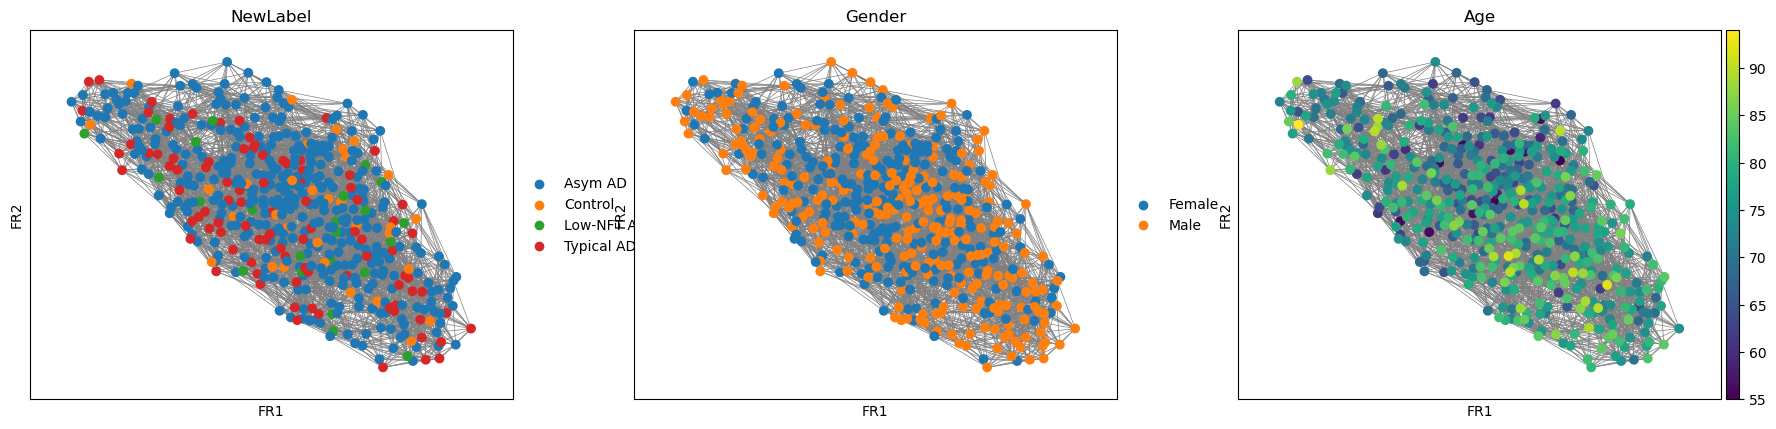

In [77]:
sc.pl.draw_graph(anndata_ADNI_Top, color=['NewLabel','Gender','Age'], legend_loc='right margin', size=200, edges=True, edges_width=0.5) 


In [78]:
sc.tl.pca(anndata_ADNI, svd_solver='arpack', n_comps=50)
sc.pp.neighbors(anndata_ADNI, n_neighbors=15, n_pcs=50)  ## avoid clustering
sc.tl.draw_graph(anndata_ADNI)

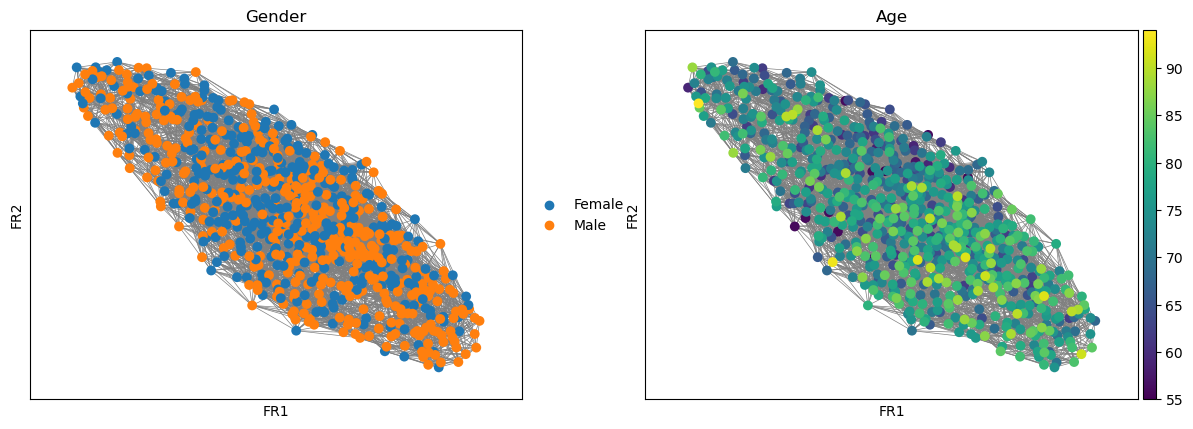

In [79]:
sc.pl.draw_graph(anndata_ADNI, color=['Gender','Age'], legend_loc='right margin', size=200, edges=True, edges_width=0.5) 
